# Import Important Libraries 

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2 as cv
import numpy as np
import plotly.express as px
import math
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import random
random.seed(42)

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau , ModelCheckpoint
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


# Load data

In [6]:
base_dir=r"C:\Users\singh\Downloads\archive\plantvillage dataset\color"
#/kaggle/input/plantvillage-dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG
folds=os.listdir(base_dir)
print(folds)

filepaths=[]
labels=[]
for fold in folds:
    folder_path=os.path.join(base_dir,fold)
    # print(folder_path)
    imgs=os.listdir(folder_path)
    for img in imgs:
        img_path=os.path.join(folder_path,img)
        filepaths.append(img_path)
        labels.append(fold)
print("Total images:", len(filepaths))
print("Total labels:", len(labels))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

# Create Dataframe 

In [7]:
data_df=pd.Series(filepaths,name='filepaths')
label_df=pd.Series(labels,name='labels')
data=pd.concat([data_df,label_df],axis=1)


In [8]:
data.labels.value_counts()

labels
Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Peach___Bacterial_spot                                2297
Tomato___Bacterial_spot                               2127
Tomato___Late_blight                                  1909
Squash___Powdery_mildew                               1835
Tomato___Septoria_leaf_spot                           1771
Tomato___Spider_mites Two-spotted_spider_mite         1676
Apple___healthy                                       1645
Tomato___healthy                                      1591
Blueberry___healthy                                   1502
Pepper,_bell___healthy                                1478
Tomato___Target_Spot                                  1404
Grape___Esca_(Black_Measles)                          1383
Corn_(maize)___Common_rust_                           1192
Grape___Black_rot                                

In [9]:
# import plotly.io as pio
# pio.renderers.default = "browser"

# label_counts = data.labels.value_counts().reset_index()
# label_counts.columns = ['Label', 'Count']

# fig = px.bar(label_counts,x='Label',y='Count',color='Count',color_continuous_scale='Greens',title='🌿 Class Distribution in PlantVillage Dataset',)

# fig.update_layout(
#     xaxis_title="Plant Disease Classes",
#     yaxis_title="Number of Images",xaxis_tickangle=-45,title_font=dict(size=22, color='#1b5e20', family='Arial'),plot_bgcolor='rgba(0,0,0,0)',
#     paper_bgcolor='rgba(0,0,0,0)',)

# fig.show()

> There is a class imbalance problem, which we can try to handle using augmentation.


# Show some samples

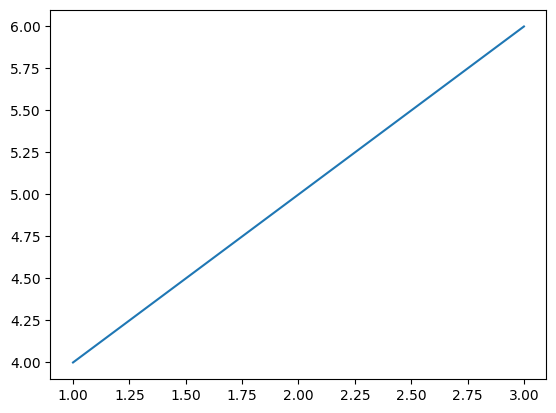

In [10]:
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()

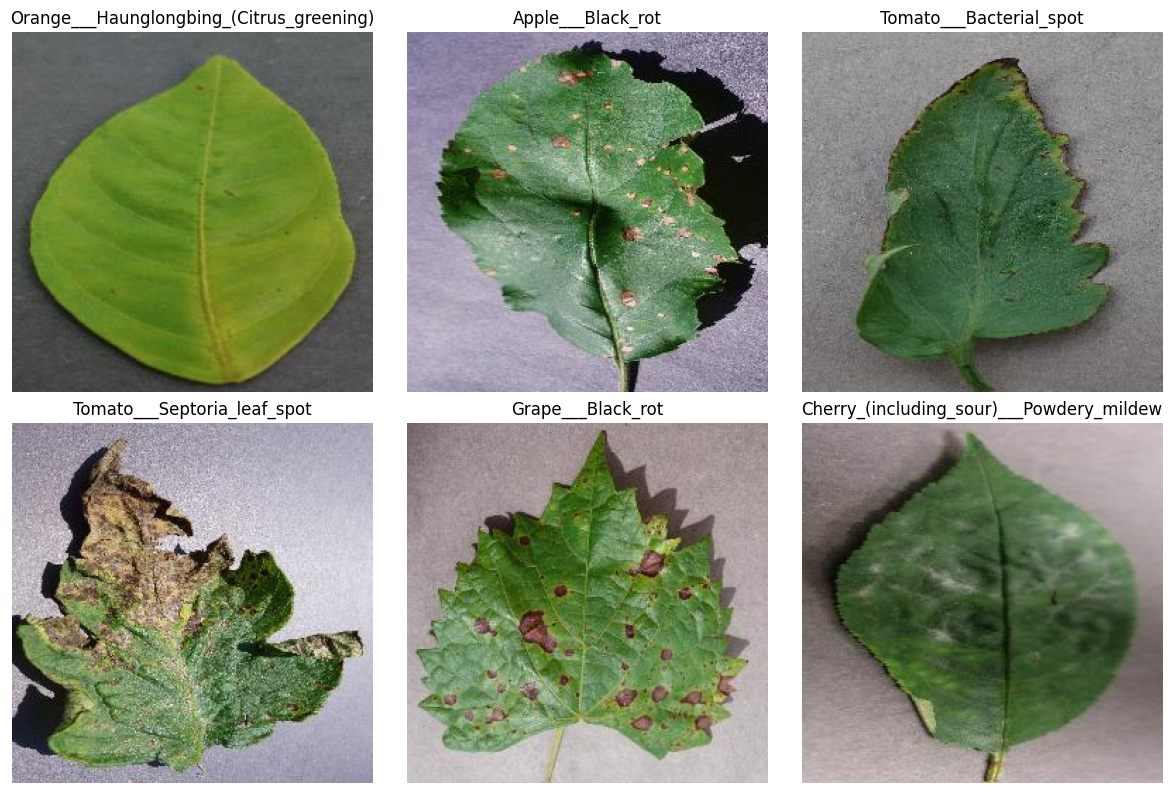

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    rand_idx = np.random.randint(0, len(data))
    img_path = data.iloc[rand_idx]['filepaths']
    lbl = data.iloc[rand_idx]['labels']
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(lbl)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Split Data into Train, Validation, and Test Sets

In [12]:
train_data, temp_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data['labels'], random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=True, stratify=temp_data['labels'], random_state=42)


In [13]:
print(len(train_data.labels.value_counts()))
print(len(test_data.labels.value_counts()))
print(len(valid_data.labels.value_counts()))

38
38
38


# Define constants

In [14]:
image_size = 224
batch_size = 32
channel = 3

# Data Agumentation

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen=ImageDataGenerator(rescale=1./255,)


In [16]:
train_gen=train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepaths',
    y_col='labels',
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(image_size,image_size),
    shuffle=True
    
)

Found 43444 validated image filenames belonging to 38 classes.


In [17]:
valid_gen=test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='filepaths',
    y_col='labels',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(image_size,image_size),
    shuffle=False
    
)

Found 5430 validated image filenames belonging to 38 classes.


In [18]:
test_gen=test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepaths',
    y_col='labels',
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(image_size,image_size),
    shuffle=False
    
)

Found 5431 validated image filenames belonging to 38 classes.


In [19]:
train_gen.class_indices.items()

dict_items([('Apple___Apple_scab', 0), ('Apple___Black_rot', 1), ('Apple___Cedar_apple_rust', 2), ('Apple___healthy', 3), ('Blueberry___healthy', 4), ('Cherry_(including_sour)___Powdery_mildew', 5), ('Cherry_(including_sour)___healthy', 6), ('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 7), ('Corn_(maize)___Common_rust_', 8), ('Corn_(maize)___Northern_Leaf_Blight', 9), ('Corn_(maize)___healthy', 10), ('Grape___Black_rot', 11), ('Grape___Esca_(Black_Measles)', 12), ('Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 13), ('Grape___healthy', 14), ('Orange___Haunglongbing_(Citrus_greening)', 15), ('Peach___Bacterial_spot', 16), ('Peach___healthy', 17), ('Pepper,_bell___Bacterial_spot', 18), ('Pepper,_bell___healthy', 19), ('Potato___Early_blight', 20), ('Potato___Late_blight', 21), ('Potato___healthy', 22), ('Raspberry___healthy', 23), ('Soybean___healthy', 24), ('Squash___Powdery_mildew', 25), ('Strawberry___Leaf_scorch', 26), ('Strawberry___healthy', 27), ('Tomato___Bacterial_spot', 

# Build CNN Model 

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, 
    Dropout, Dense, 
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam

model = Sequential([

    Conv2D(16, (3,3), activation='relu', padding='same',
           input_shape=(image_size, image_size, channel)),
    MaxPooling2D((2,2)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Dropout(0.3),

    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [21]:
# model=Sequential([
#     Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(image_size,image_size,channel)),
#     Conv2D(64,(3,3),activation='relu',padding='same'),
#     MaxPooling2D((2,2)),

#     Conv2D(64,(3,3),activation='relu',padding='same'),
#     Conv2D(64,(3,3),activation='relu',padding='same'),
#     MaxPooling2D((2,2)),
    
#     Conv2D(128,(3,3),activation='relu',padding='same'),
#     Conv2D(128,(3,3),activation='relu',padding='same'),
#     MaxPooling2D((2,2)),
#     Dropout(0.2),

#     Flatten(),
#     Dense(256,activation='relu'),
#     Dense(128,activation='relu'),
#     Dropout(0.5),
#     Dense(len(train_gen.class_indices),activation='softmax')

# ])

# model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])



In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,214 (118.02 KB)

 Trainable params: 30,214 (118.02 KB)

 Non-trainable params: 0 (0.00 B)

# Define callbacks 

In [23]:
callbacks = [EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(factor=0.3, patience=2, monitor='val_loss', verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)]

# Train Model

In [24]:
history=model.fit(train_gen,epochs=11,validation_data=valid_gen,callbacks=callbacks, verbose=1)

Epoch 1/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2169 - loss: 3.0065
Epoch 1: val_loss improved from None to 1.84144, saving model to best_model.h5



Epoch 1: finished saving model to best_model.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1614s 1s/step - accuracy: 0.2854 - loss: 2.6462 - val_accuracy: 0.4812 - val_loss: 1.8414 - learning_rate: 0.0010
Epoch 2/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.4399 - loss: 1.9069
Epoch 2: val_loss improved from 1.84144 to 1.42789, saving model to best_model.h5



Epoch 2: finished saving model to best_model.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1436s 1s/step - accuracy: 0.4710 - loss: 1.7921 - val_accuracy: 0.5713 - val_loss: 1.4279 - learning_rate: 0.0010
Epoch 3/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.5373 - loss: 1.5354
Epoch 3: val_loss improved from 1.42789 to 1.20422, saving model to best_model.h5



Epoch 3: finished saving model to best_model.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1397s 1s/step - accuracy: 0.5597 - loss: 1.4620 - val_accuracy: 0.6339 - val_loss: 1.2042 - learning_rate: 0.0010
Epoch 4/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5988 - loss: 1.3250
Epoch 4: val_loss improved from 1.20422 to 1.03138, saving model to best_model.h5



Epoch 4: finished saving model to best_model.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1462s 1s/step - accuracy: 0.6086 - loss: 1.2900 - val_accuracy: 0.6731 - val_loss: 1.0314 - learning_rate: 0.0010
Epoch 5/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.6283 - loss: 1.2130
Epoch 5: val_loss did not improve from 1.03138
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1443s 1s/step - accuracy: 0.6381 - loss: 1.1816 - val_accuracy: 0.6814 - val_loss: 1.0472 - learning_rate: 0.0010
Epoch 6/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.6602 - loss: 1.1137
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 6: val_loss did not improve from 1.03138
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1396s 1s/step - accuracy: 0.6632 - loss: 1.1002 - val_accuracy: 0.6880 - val_loss: 1.0333 - learning_rate: 0.0010
Epoch 7/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6993 - loss: 0.9818
Epoch 7: val_loss improved from 1.03138 to 0.88034, saving model to best_model


Epoch 7: finished saving model to best_model.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1459s 1s/step - accuracy: 0.7026 - loss: 0.9718 - val_accuracy: 0.7293 - val_loss: 0.8803 - learning_rate: 3.0000e-04
Epoch 8/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.7093 - loss: 0.9534
Epoch 8: val_loss improved from 0.88034 to 0.80060, saving model to best_model.h5



Epoch 8: finished saving model to best_model.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1400s 1s/step - accuracy: 0.7082 - loss: 0.9482 - val_accuracy: 0.7483 - val_loss: 0.8006 - learning_rate: 3.0000e-04
Epoch 9/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7119 - loss: 0.9352
Epoch 9: val_loss improved from 0.80060 to 0.73709, saving model to best_model.h5



Epoch 9: finished saving model to best_model.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1459s 1s/step - accuracy: 0.7147 - loss: 0.9277 - val_accuracy: 0.7681 - val_loss: 0.7371 - learning_rate: 3.0000e-04
Epoch 10/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.7225 - loss: 0.8995
Epoch 10: val_loss did not improve from 0.73709
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1395s 1s/step - accuracy: 0.7228 - loss: 0.8998 - val_accuracy: 0.7394 - val_loss: 0.8409 - learning_rate: 3.0000e-04
Epoch 11/11
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7223 - loss: 0.9000
Epoch 11: val_loss improved from 0.73709 to 0.73393, saving model to best_model.h5



Epoch 11: finished saving model to best_model.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1501s 1s/step - accuracy: 0.7244 - loss: 0.8920 - val_accuracy: 0.7707 - val_loss: 0.7339 - learning_rate: 3.0000e-04
Restoring model weights from the end of the best epoch: 11.


# Evaluate Model 

In [25]:
loss_train,accuracy_train=model.evaluate(train_gen)
loss_valid,accuracy_valid=model.evaluate(valid_gen)
loss_test,accuracy_test=model.evaluate(test_gen)

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1121s 826ms/step - accuracy: 0.8159 - loss: 0.6200
170/170 ━━━━━━━━━━━━━━━━━━━━ 79s 468ms/step - accuracy: 0.7707 - loss: 0.7339
170/170 ━━━━━━━━━━━━━━━━━━━━ 89s 525ms/step - accuracy: 0.7755 - loss: 0.7273


In [26]:
print(f'Loss Train: {loss_train},Accuracy Train: {accuracy_train}')
print(f'Loss Valid: {loss_valid},Accuracy Valid: {accuracy_valid}')
print(f'Loss Test: {loss_test},Accuracy Test: {accuracy_test}')

Loss Train: 0.6200157403945923,Accuracy Train: 0.8159009218215942
Loss Valid: 0.7339326739311218,Accuracy Valid: 0.7707182168960571
Loss Test: 0.7272591590881348,Accuracy Test: 0.7755478024482727


* Model generalizes very well — no overfitting (training, validation, and test scores are close).

* Test accuracy of 96.6% on a large, multi-class dataset (with imbalance) indicates strong performance.

# Model Preformance Train VS Loss

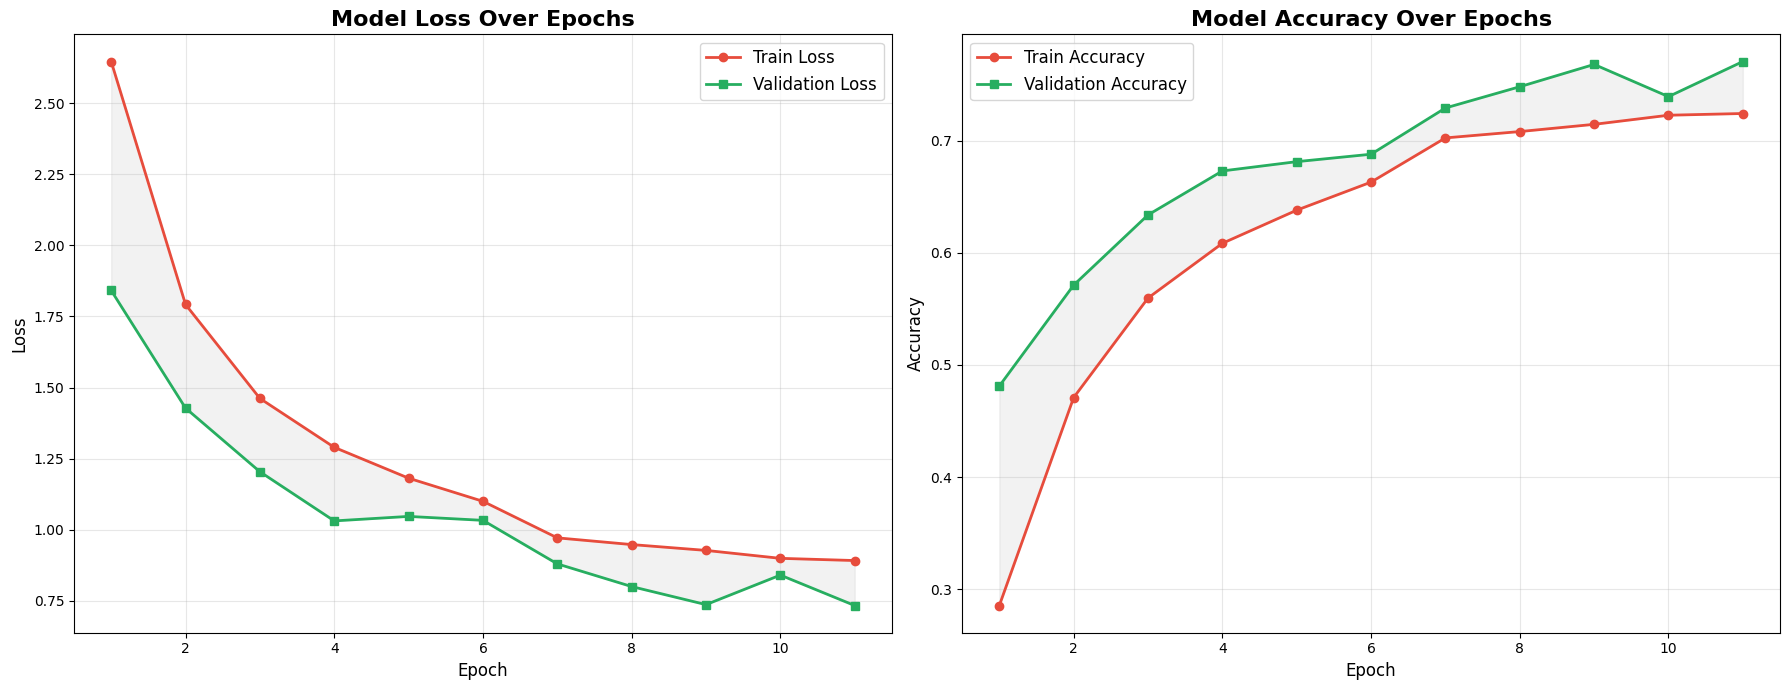

In [27]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(tr_acc) + 1)

plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, color='#E74C3C', linewidth=2, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, color='#27AE60', linewidth=2, marker='s', label='Validation Loss')
plt.fill_between(epochs, val_loss, tr_loss, color='gray', alpha=0.1)  
plt.title('Model Loss Over Epochs', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, color='#E74C3C', linewidth=2, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, color='#27AE60', linewidth=2, marker='s', label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs', fontsize=16, weight='bold')
plt.fill_between(epochs, val_acc, tr_acc, color='gray', alpha=0.1)  
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()


### Model Evaluation 

* **Loss:** Train loss ↓ from ~2.5 → 0.16; Val loss ↓ to ~0.12. Smooth curves, good convergence, minimal overfitting.

* **Accuracy:** Train ↑ ~0.3 → 0.95; Val ↑ ~0.46 → 0.96. Validation slightly higher, indicates good generalization.

* **Overall:** Model converged well, high accuracy (~95–96%), low loss.

# Prediction 

In [28]:
def preprocess(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    resized = img.resize(target_size)
    img_array = np.array(resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

In [29]:
def prediction(model,img_path,class_indices):
  preprocessed_img = preprocess(img_path)
  predictions = model.predict(preprocessed_img)
  predicted_class_index = np.argmax(predictions, axis=1)[0]
  predicted_class_name = class_indices[predicted_class_index]
  return predicted_class_name

In [30]:
class_indices = {v: k for k, v in train_gen.class_indices.items()}
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [32]:
image_path = r"C:\Users\singh\Downloads\archive\plantvillage dataset\color\Apple___Apple_scab\0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417.JPG"
predicted_class_name = prediction(model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Predicted Class Name: Orange___Haunglongbing_(Citrus_greening)


In [33]:
image_path = r'C:\Users\singh\Downloads\archive\plantvillage dataset\color\Apple___Apple_scab\0d3c0790-7833-470b-ac6e-94d0a3bf3e7c___FREC_Scab 2959.JPG'
predicted_class_name = prediction(model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Class Name: Blueberry___healthy


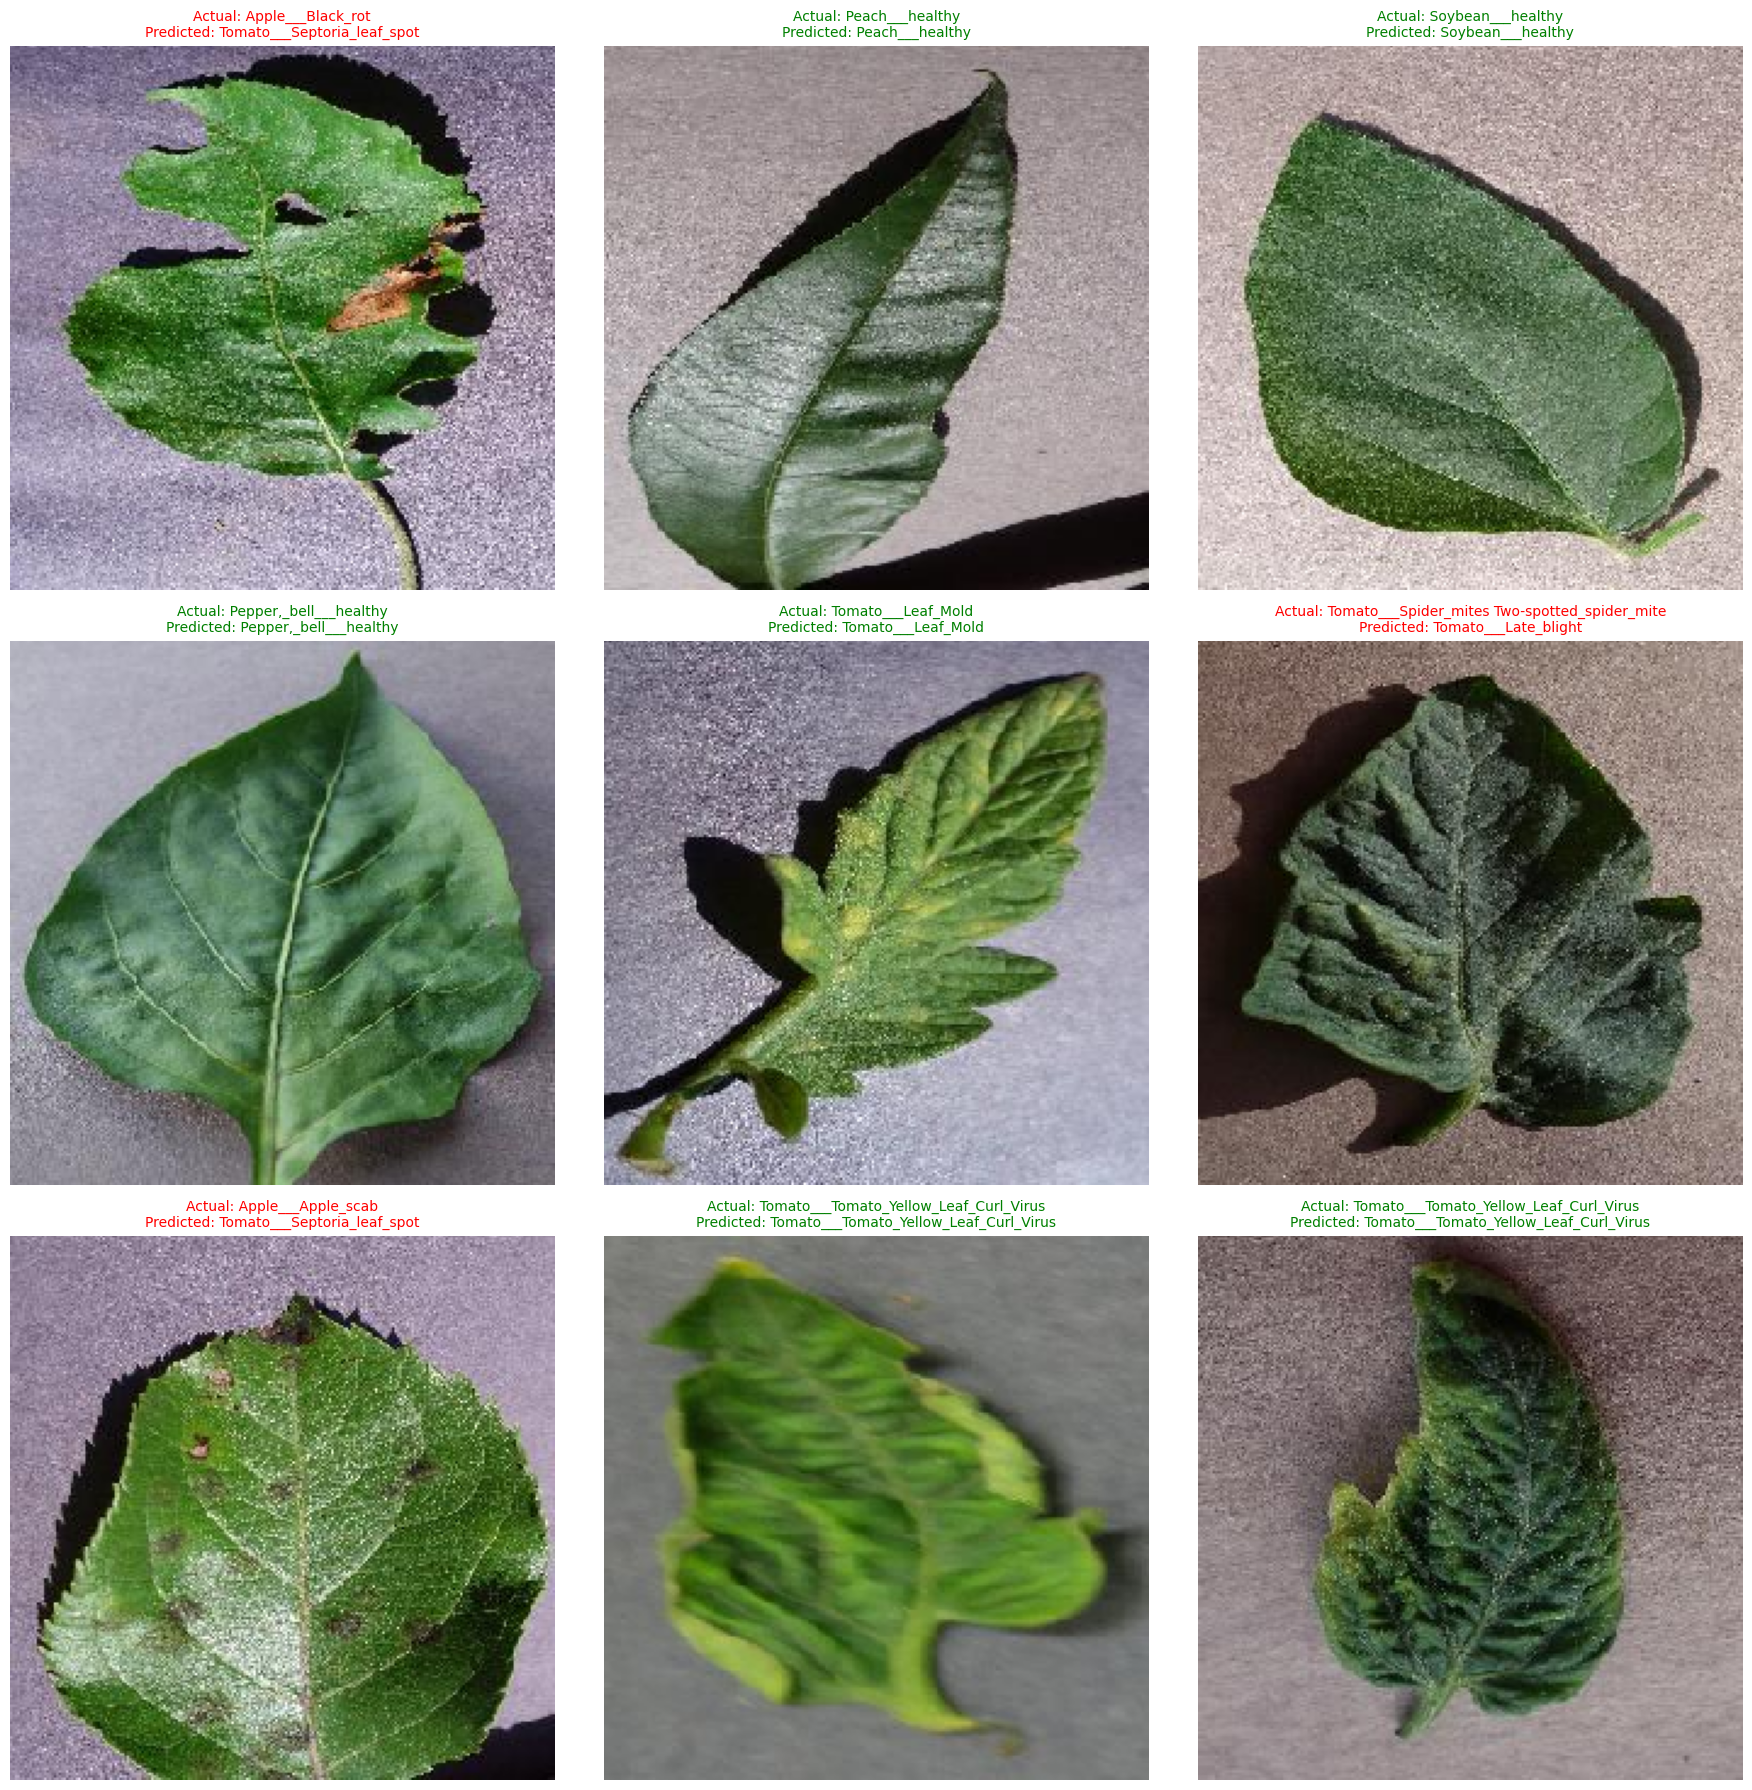

In [34]:
plt.figure(figsize=(18,18))

images, labels = next(test_gen)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label_idx = np.argmax(labels[i])
    actual = class_indices[true_label_idx]

    preds = model.predict(np.expand_dims(images[i], axis=0), verbose=0)
    pred_label_idx = np.argmax(preds)
    predict = class_indices[pred_label_idx]

    color = 'green' if actual == predict else 'red' #ternnary statement 
    plt.title(f"Actual: {actual}\nPredicted: {predict}", color=color, fontsize=10)

plt.tight_layout()
plt.show()


170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step


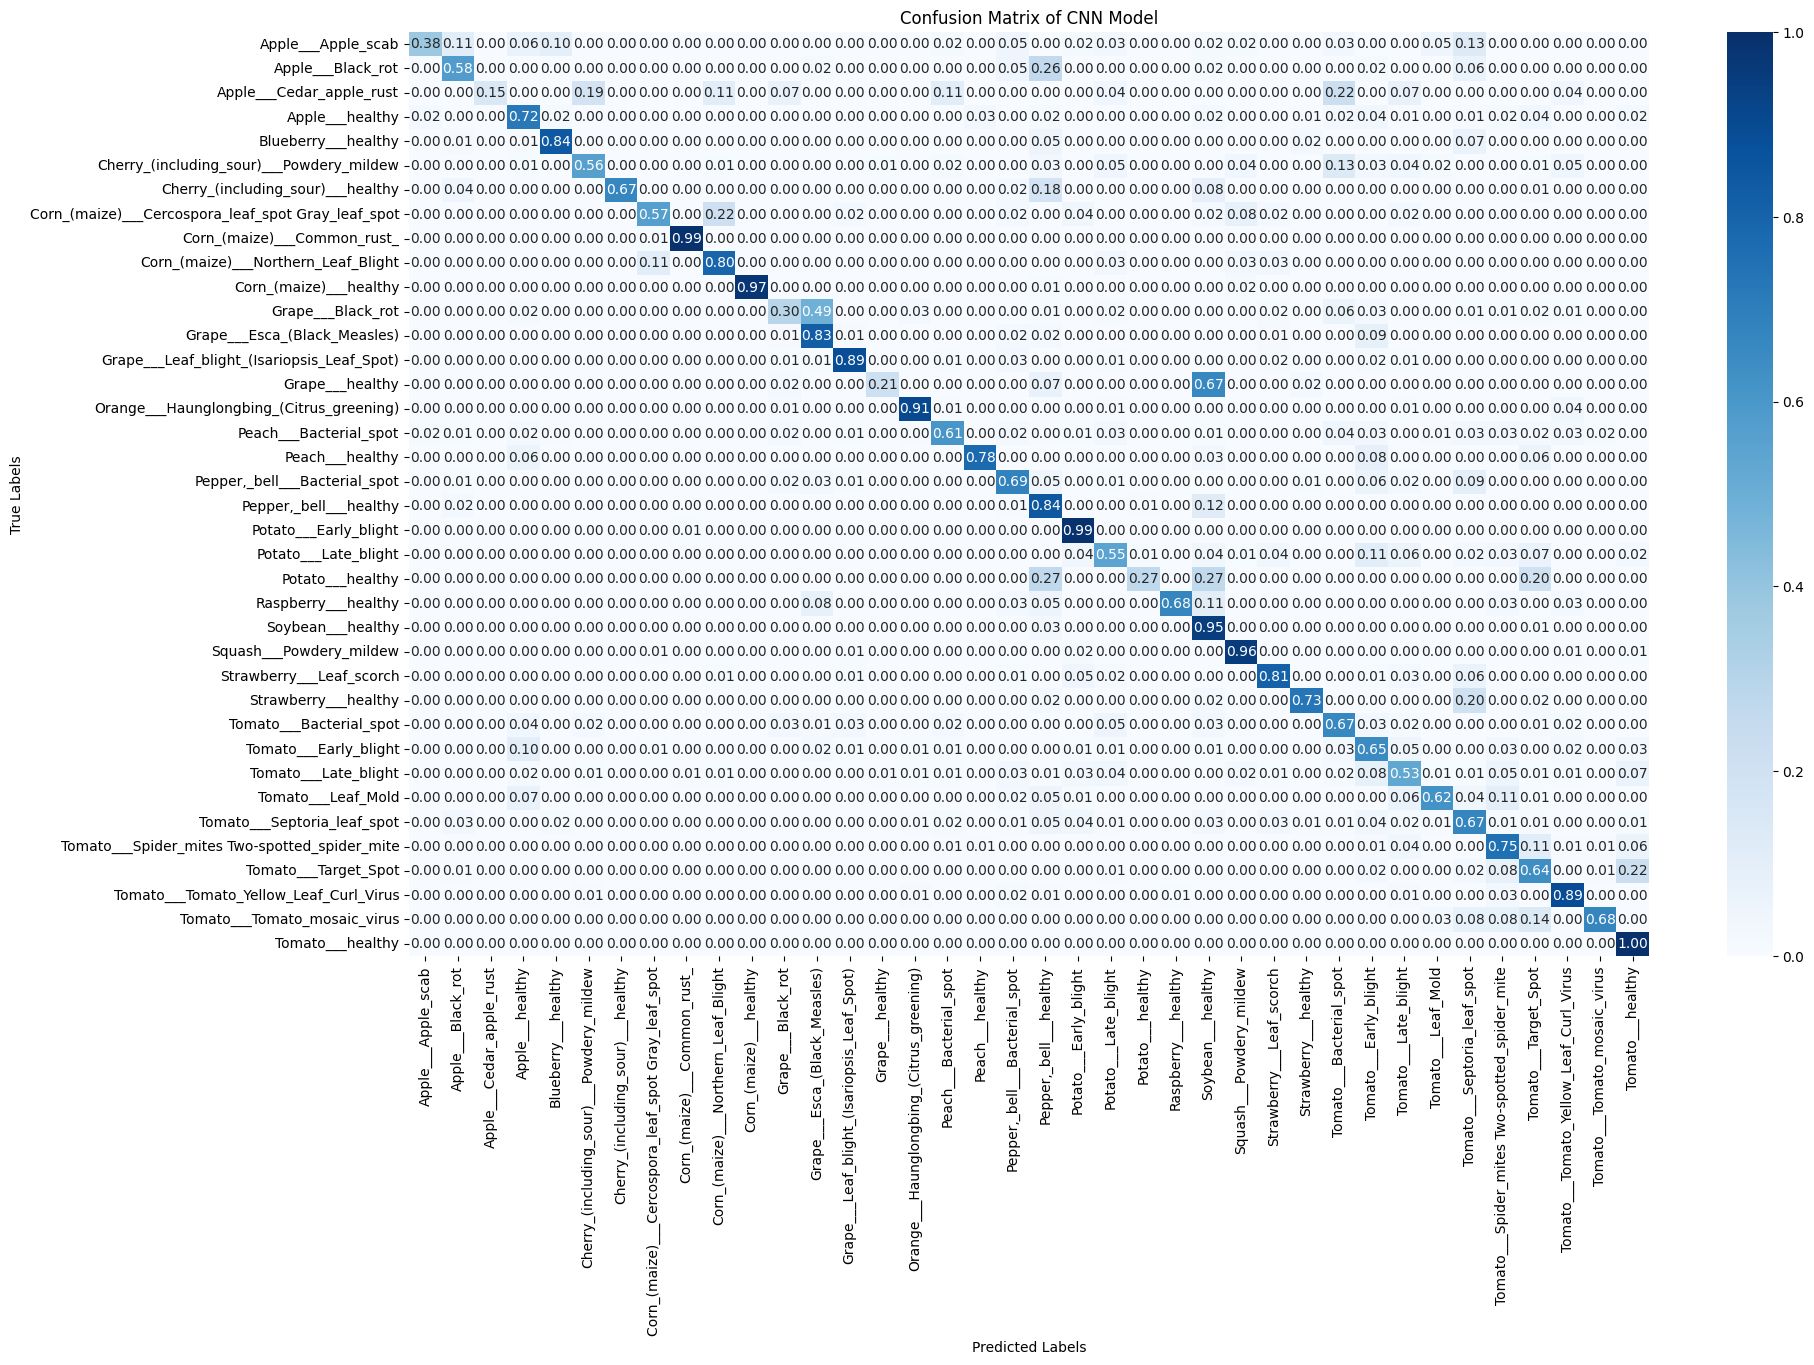


Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.73      0.38      0.50        63
                                 Apple___Black_rot       0.60      0.58      0.59        62
                          Apple___Cedar_apple_rust       1.00      0.15      0.26        27
                                   Apple___healthy       0.72      0.72      0.72       165
                               Blueberry___healthy       0.89      0.84      0.87       150
          Cherry_(including_sour)___Powdery_mildew       0.79      0.56      0.66       105
                 Cherry_(including_sour)___healthy       1.00      0.67      0.80        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.67      0.57      0.62        51
                       Corn_(maize)___Common_rust_       0.98      0.99      0.99       120
               Corn_(maize)___Northern_Leaf_Blight    

In [37]:
import seaborn as sns

y_true = test_gen.classes

y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes,normalize='true')

class_names = list(test_gen.class_indices.keys())

plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of CNN Model')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))
